# CS145: Project 3 | A Wise Taxi Driver: Predicting Taxi Fare and Trip Duration in NYC

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Yiting Zhao, yitzhao*
* *Yichen Liu, yliu21*

## Project Overview

---

Imagine you are a taxi driver driving a yellow cab in NYC, and you want to have a better understanding of the taxi fare and the trip duration after a new passenger hops onto your cab so that you can plan your routes accordingly to earn more money. 

**Therefore, the central question of this project is: can we predict taxi fares and taxi trip durations based on some given information that the taxi drive can acquire after the passenger hops onto your cab.**

To approach the question, we examined the following features and their correlation with taxi fares or trip durations:



*   What is the correlation between locations, either pick-up or drop-off, and taxi fares or trip durations? Note that we explored the mechanisms through which locations affect taxi fares or trip durations as well as some engineered features derived from pick-up and drop-off locations.
*   What is the correlation between the timestamp when the taxi trip occurs and taxi fares or trip durations? Note that we can further break down the timestamp feature into several features such as hour of day and day of week.
*   What is the correlation between the number of passengers and taxi fares or trip durations?
*   What is the correlation between weather and taxi fares or trip durations? By weather, note that we are interested in both temperatures and some selected weather conditions such as fog and snow.



---


## Analysis of Dataset

---
We used tables from different datasets. The most important dataset is *new_york_taxi_trips*, which contains information about records of taxi trips in NYC in each year and the geological information of each region designated by the taxi company. We mainly used the following tables from this dataset:


*   tlc_yellow_trips_2016: 17.48 GB and 131,165,043 rows. This table contains information for taxi trips in 2016. It contains keys such as pickup_longitude, pickup_latitude, dropoff_longitude dropoff_latitude, pickup_datetime, dropoff_datetime, passenger_count, fare_amount, and tolls_amount from taxi trips in 2016. Among them, total fare (fare_amount + tolls_amount) and duration (difference between pickup_datetime and dropoff_datetime) are the dependent variables (Y) that we are interested in predicting. Features extracted from the remaining mentioned keys are potential independent variables (X) that we are interested in researching their correlation with Y.
*   tlc_yellow_trips_2018: 18.14 GB and 112,234,626 rows. This table contains information for taxi trips in 2018. The schema of this table is similar to tlc_yellow_trips_2016 albeit the fact that it does not include longitude/latitude info but pickup_location_id and droppoff_location_id, i.e., pickup/dropoff location's region id designated by the taxi company. Joining this table with taxi_zone_geom mentioned below will provide us with the exact names of the pickup/dropoff locations (example: Midtown South or Brooklyn Heights) rather than the hard-to-comprehend-at-first longitude/latitude. The pickup_location_id and dropoff_location_id are foreign keys referring to the zone_id in taxi_zone_geom. We only used this table when researching the correlation between pickup/dropoff locations and the dependent variables (total fare and duration) in the data exploration part, assuming that the discovered correlation persists both in 2016 and 2018.


*   taxi_zone_geom: 2.49 MB and 263 rows. This table records the region id designated by the taxi company. It contains keys such as zone_id, zone_name, and zone_geom. In this table, zone_id is the primary key. Joining this table with  tlc_yellow_trips_2018 will allow us to extract the exact names of pickup/dropoff locations as mentioned above.

We also used another dataset *noaa_gsod*, which contains information about the worldwide daily weather records in each year and the records of weather stations. We mainly used the following tables from this dataset:


*   gsod2016: 775.17 MB and 4,292,866 rows. This tables contains information about weather records in 2016. Some important included keys are stn, wban (stn and wban are foreign keys pointing to usaf and wban in the station table documenting each weather station), mo (month), da (day), temp, fog, rain_drizzle, snow_ice_pellets, hail, thunder, and tornado_funnel_cloud. 
*   station: 2.31 MB and 29,590 rows. This table documents the information for each weather station. Some important included keys are usaf, wban (usaf and wban together are primary keys identifying each weather station, they are pointed by the foreign keys in gsod2016), name, country, state, lat (latitude), lon(longitude). Joining this table with gsod2016 will allow us to know the location of each station that produced records in gsod2016. Further cross-joining with taxi_zone_geom will allow us to filter weather stations in NYC via GIS functions: ST_COVERS(taxi_zone_geom.zone_geom,ST_GEOGPOINT(station.lon,station.lat)) is TRUE. We can join the result table with tlc_yellow_trips_2016 on matching month and day to get the weather condition of each taxi trip in tlc_yellow_trips_2016. Note that we refer to this table as noaa_gsod_station in the schema diagram to avoid confusion. 

The last dataset we used is *new_york_subway*. This table contains the information for subway records in NYC. We mainly used the following tables from this dataset:

*   station: 75.04 KB and 496 rows. This table ducuments the information for each subway station in NYC. Some important included keys are station_lat (latitude) and station_lon(longitude). In the Data Exploration section 1E, we cross joined this table with tlc_yellow_trips_2016 to acquire the number of nearby subway stations around the pick-up location in each taxi trip via GIS functions:
ST_DISTANCE(ST_GEOGPOINT(a.pickup_longitude,a.pickup_latitude),ST_GEOGPOINT(b.station_lon,b.station_lat)) < 500. We defined "nearby" as such that the distance between a subway station and the pick-up location is smaller than 500 meters. Note that we refer to this table as new_york_subway_station in the schema diagram to avoid confusion. 



----

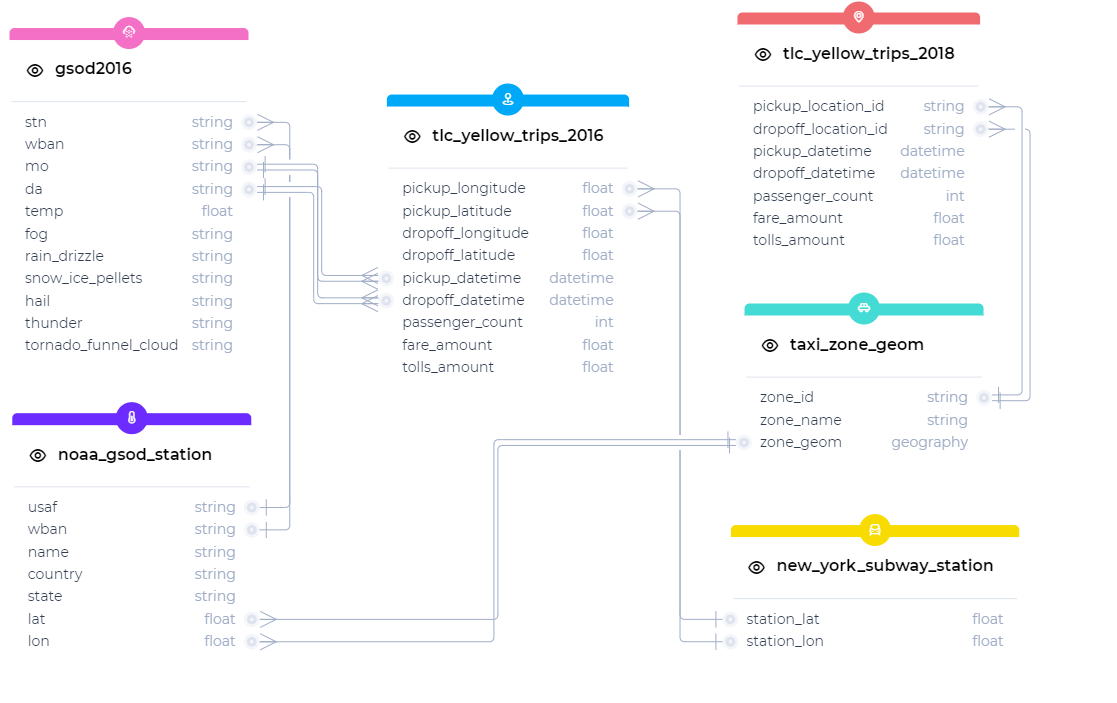

## Data Exploration

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-yitzhao"

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "canvas-voltage-328019"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

### Location




---
We are interested in finding the correlation between pick-up/drop-off locations and taxi fare or trip duration, i.e., which pick-up/drop-off location is associated with higher taxi fare or longer duration. However, only knowing the associated taxi fare value or duration value for each individual pick-up/drop-off location, though sufficient for using them in the final prediction model, provides little information on the mechanisms and channels through which locations and taxi fare or duration are correlated. Therefore, we provided a detailed analysis on the potential mechanisms through which pick-up/drop-off locations cast their impact on taxi fare and duration. We also engineered some features and studied their correlation with taxi fare and duration.


---



#### A. The Number of Occurrences of Pick-up Locations versus Taxi Fare and Duration 





---
One hypothesis that we have in mind is that some pick-up locations have higher occurrences than the others, for example: central business districts, transportation hubs, worksites, or densely populated residential areas. We suspected that these popular pick-up locations are correlated with shorter trip distance since passengers from these pick-up locations tend to be commuters, resulting in lower taxi fare and shorter trip duration. In the following queries and plots, we first discovered that more popular pick-up locations exist and tend to be central business districts, transportation hubs, worksites, or densely populated residential areas (for example, Upper East Side South or Penn Station). We then discovered that higher occurrences of pick-up locations are indeed associated with lower taxi fares and shorter trip durations as shown in the plots.


---



In [ ]:
%%bigquery --project $project_id df1

SELECT 
b.zone_id,
b.zone_name,
count(*) as occurrence
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018` a
LEFT JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b 
on a.pickup_location_id = b.zone_id
group by 1,2
order by 3 desc

In [ ]:
df11 = df1.iloc[:10,:]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

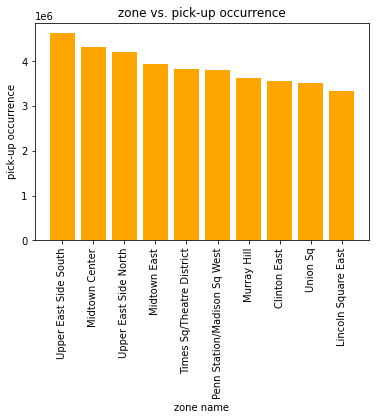

In [ ]:
plt.bar(df11["zone_name"], df11["occurrence"], color="orange")
plt.title("zone vs. pick-up occurrence")
plt.xlabel("zone name")
plt.ylabel("pick-up occurrence")
plt.xticks(rotation = 90)

In [ ]:
df12 = df1.iloc[-10:,:]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

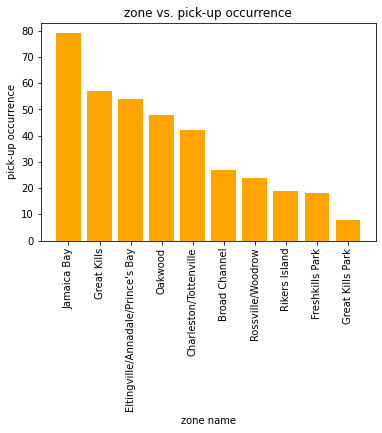

In [ ]:
plt.bar(df12["zone_name"], df12["occurrence"], color="orange")
plt.title("zone vs. pick-up occurrence")
plt.xlabel("zone name")
plt.ylabel("pick-up occurrence")
plt.xticks(rotation = 90)



---


Conclusion: Some pick-up locations are indeed more 
popular than the others.


---



In [ ]:
%%bigquery --project $project_id df2

SELECT 
b.zone_id,
b.zone_name,
count(*) as occurrence,
avg(tolls_amount+fare_amount) as avg_fare,
avg(TIMESTAMP_DIFF(a.dropoff_datetime,a.pickup_datetime,MINUTE)) as avg_duration
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018` a
LEFT JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b 
on a.pickup_location_id = b.zone_id
WHERE TIMESTAMP_DIFF(a.dropoff_datetime,a.pickup_datetime,MINUTE) > 1
group by 1,2
order by 3 desc

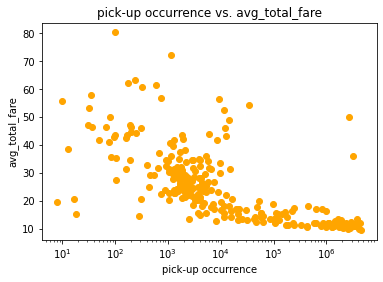

In [ ]:
plt.scatter(df2["occurrence"], df2["avg_fare"], color="orange")
plt.title("pick-up occurrence vs. avg_total_fare")
plt.xlabel("pick-up occurrence")
plt.ylabel("avg_total_fare")
plt.xscale('log')

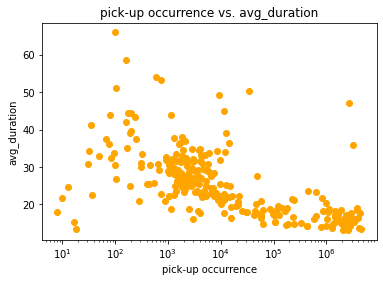

In [ ]:
plt.scatter(df2["occurrence"], df2["avg_duration"], color="orange")
plt.title("pick-up occurrence vs. avg_duration")
plt.xlabel("pick-up occurrence")
plt.ylabel("avg_duration")
plt.xscale('log')

#### B. The Number of Occurrences of Drop-off Locations versus Taxi Fare and Duration




---
Based on the same rationale, we examined whether drop-off locations with higher occurrences tend to correlate with lower taxi fare and shorter trip duration as well. In the following queries and plots, we first discovered that more popular drop-off locations exist and also tend to be central business districts, transportation hubs, worksites, or densely populated residential areas. We then discovered that higher occurrences of drop-off locations are indeed associated with lower taxi fares and shorter trip durations as shown in the plots.


---



In [ ]:
%%bigquery --project $project_id df3

SELECT 
b.zone_id,
b.zone_name,
count(*) as occurrence
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018` a
LEFT JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b 
on a.dropoff_location_id = b.zone_id
group by 1,2
order by 3 desc

In [ ]:
df31 = df3.iloc[:10,:]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

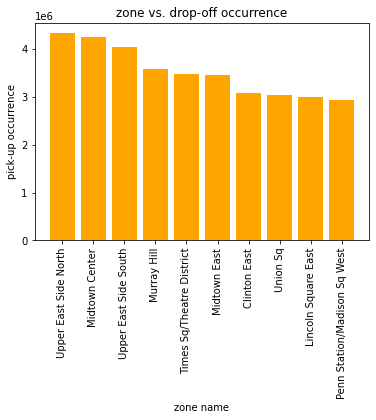

In [ ]:
plt.bar(df31["zone_name"], df31["occurrence"], color="orange")
plt.title("zone vs. drop-off occurrence")
plt.xlabel("zone name")
plt.ylabel("pick-up occurrence")
plt.xticks(rotation = 90)

In [ ]:
df32 = df3.iloc[-10:,:]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

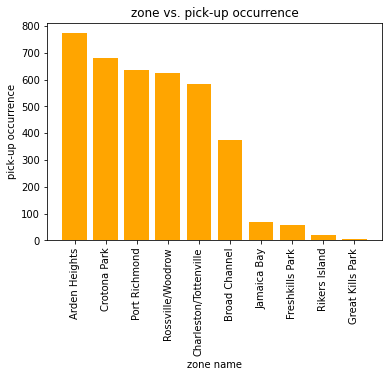

In [ ]:
plt.bar(df32["zone_name"], df32["occurrence"], color="orange")
plt.title("zone vs. pick-up occurrence")
plt.xlabel("zone name")
plt.ylabel("pick-up occurrence")
plt.xticks(rotation = 90)



---


Conclusion: Some drop-off locations are indeed more popular than the others.


---



In [ ]:
%%bigquery --project $project_id df4

SELECT 
b.zone_id,
b.zone_name,
count(*) as occurrence,
avg(tolls_amount+fare_amount) as avg_fare,
avg(TIMESTAMP_DIFF(a.dropoff_datetime,a.pickup_datetime,MINUTE)) as avg_duration
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018` a
LEFT JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b 
on a.dropoff_location_id = b.zone_id
WHERE TIMESTAMP_DIFF(a.dropoff_datetime,a.pickup_datetime,MINUTE) > 1
group by 1,2
order by 3 desc

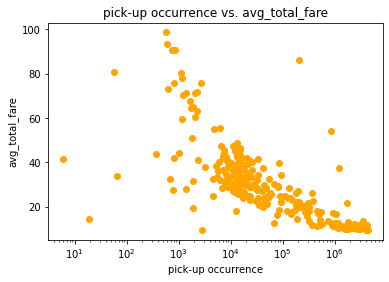

In [ ]:
plt.scatter(df4["occurrence"], df4["avg_fare"], color="orange")
plt.title("pick-up occurrence vs. avg_total_fare")
plt.xlabel("pick-up occurrence")
plt.ylabel("avg_total_fare")
plt.xscale('log')

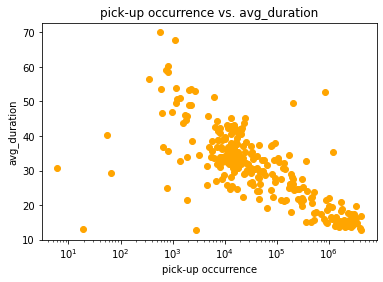

In [ ]:
plt.scatter(df4["occurrence"], df4["avg_duration"], color="orange")
plt.title("pick-up occurrence vs. avg_duration")
plt.xlabel("pick-up occurrence")
plt.ylabel("avg_duration")
plt.xscale('log')

#### C.Euclidean Distance between Pick-up and Drop-off versus Taxi Fare and Duration




---
With the above information in mind, we tried to engineer the features of pick-up locations and drop-off locations. By doing so, we hope that more information can be attained so that the new engineered feature can be useful in achieving better prediction accuracies in the following data prediction section. The classic way of doing so is to acquire the euclidean distance between the pick-up location and the drop-location in each taxi trip. The correlation between euclidean distances and taxi fare or duration is hypothetically sound and solid since larger euclidean distances are associated with larger trip distances (the latter will be larger than the former though since the former is the shortest distance between two points on earth) and thus and correlated with higher taxi fare and longer trip duration. The following queries and plots corroborated this hypothesis by showing positive correlations between pick-up drop-off euclidean distances and taxi fare as well as between pick-up drop-off euclidean distances and trip duration. Realistically speaking, to know the value of this feature, our taxi driver needs to be a skillful mathematician to compute euclidean distances between the pick-up location and the passenger’s destination. Easy Peasy!


---



In [ ]:
%%bigquery --project $project_id euclidean
SELECT 
ST_DISTANCE(ST_CENTROID(b.zone_geom), ST_CENTROID(c.zone_geom)) AS euclidean_distance, 
AVG(tolls_amount+fare_amount) as avg_fare, AVG(TIMESTAMP_DIFF(a.dropoff_datetime,a.pickup_datetime,MINUTE)) as avg_duration
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018` a
LEFT JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b 
ON a.pickup_location_id = b.zone_id
LEFT JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` c
ON a.dropoff_location_id = c.zone_id
WHERE ST_DISTANCE(ST_CENTROID(b.zone_geom), ST_CENTROID(c.zone_geom)) > 0
GROUP BY euclidean_distance

(0.0, 300.0)

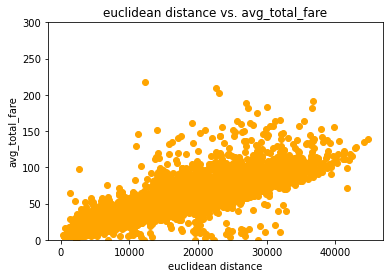

In [ ]:
plt.scatter(euclidean["euclidean_distance"], euclidean["avg_fare"], color="orange")
plt.title("euclidean distance vs. avg_total_fare")
plt.xlabel("euclidean distance")
plt.ylabel("avg_total_fare")
plt.ylim(0, 300)

(0.0, 500.0)

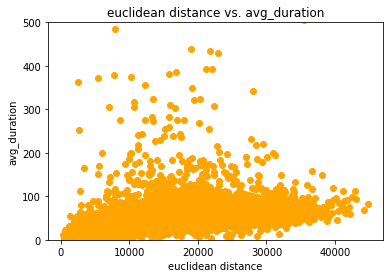

In [ ]:
plt.scatter(euclidean["euclidean_distance"], euclidean["avg_duration"], color="orange")
plt.title("euclidean distance vs. avg_duration")
plt.xlabel("euclidean distance")
plt.ylabel("avg_duration")
plt.ylim(0, 500)

#### D. Pick-up Drop-off Location Pairs versus Taxi Fare and Duration




---
Based on the correlation we had discovered in A and B, another way of feature engineering is to combine them into pairs. Hypothetically, pick-up drop-off location pairs should preserve the correlation with taxi fare and trip duration that we discovered in A and B. The following queries and plots corroborated this hypothesis by showing that higher occurrences of pick-up drop-off location pairs are indeed associated with lower taxi fares and shorter trip durations as shown in the plots.


---



In [ ]:
%%bigquery --project $project_id pair
SELECT
CONCAT(ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)),ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1))) location_fc,
avg(tolls_amount + fare_amount) AS avg_total,
avg(TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE)) as avg_duration,
COUNT(*) AS occurrences
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
group by 1

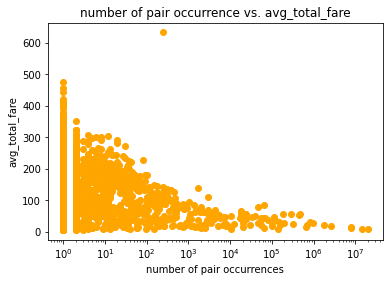

In [ ]:
plt.scatter(pair["occurrences"], pair["avg_total"], color="orange")
plt.title("number of pair occurrence vs. avg_total_fare")
plt.xlabel("number of pair occurrences")
plt.ylabel("avg_total_fare")
plt.xscale('log')

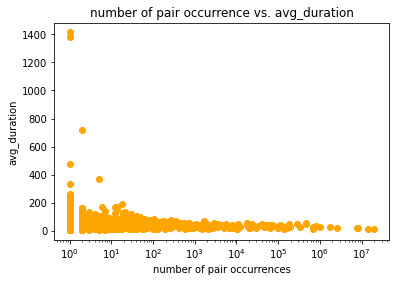

In [ ]:
plt.scatter(pair["occurrences"], pair["avg_duration"], color="orange")
plt.title("number of pair occurrence vs. avg_duration")
plt.xlabel("number of pair occurrences")
plt.ylabel("avg_duration")
plt.xscale('log')

#### E. Number of Nearby Subway Stations around Pick-up Locations versus Taxi Fare and Duration 




---
Other than the number of occurrences of pick-up or drop-off locations, another hypothesis on the mechanisms and channels through which locations affect taxi fare and duration is that pick-up locations with more subway stations nearby are associated with higher taxi fare and longer trip duration. We defined "nearby" as within 500 meters, a reasonable definition in the case of NYC. The rationale is that if passengers are near many subway stations in NYC and still choose to take taxi cabs, it is very likely that they are going to some places far away since the subway system in NYC covers a lot of the areas in the center already. The following queries and plots corroborated this hypothesis by showing that larger numbers of nearby subway stations around pick-up locations is indeed associated with higher taxi fares and longer trip durations as shown in the plots. We must admit though that some anomalies that we cannot explain for now exist: when the number of nearby subway stations is 0, we witness that the associated taxi fare is high and the associated trip duration is long. One potential explanation is that since the subway system in NYC is relatively advanced, it is rare that there is no subway station nearby. Therefore, the data that contribute to the nearby station = 0 case occupy only a tiny portion in our dataset, leading to more variance and anomalies.


---



In [ ]:
%%bigquery --project $project_id subway
SELECT
c.nearby,
AVG(c.total) AS avg_total,
AVG(TIMESTAMP_DIFF(c.dropoff_datetime,c.pickup_datetime,MINUTE)) as avg_duration
FROM 
(
SELECT 
a.pickup_datetime,
a.dropoff_datetime,
a.pickup_latitude,
a.pickup_longitude,
a.dropoff_latitude,
a.dropoff_longitude,
(a.tolls_amount+a.fare_amount) as total,
SUM(CASE 
WHEN ST_DISTANCE(ST_GEOGPOINT(a.pickup_longitude,a.pickup_latitude),ST_GEOGPOINT(b.station_lon,b.station_lat))<500 then 1
else 0
END) AS nearby
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016` a
CROSS JOIN `bigquery-public-data.new_york_subway.stations` b
GROUP BY 1,2,3,4,5,6,7)c
GROUP BY c.nearby

Text(0, 0.5, 'avg_total_fare')

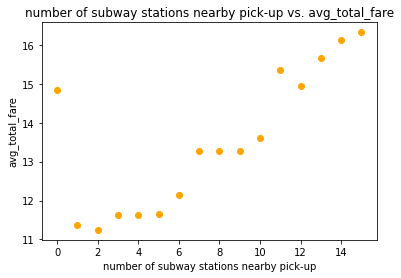

In [ ]:
plt.scatter(subway["nearby"], subway["avg_total"], color="orange")
plt.title("number of subway stations nearby pick-up vs. avg_total_fare")
plt.xlabel("number of subway stations nearby pick-up")
plt.ylabel("avg_total_fare")

Text(0, 0.5, 'avg_duration')

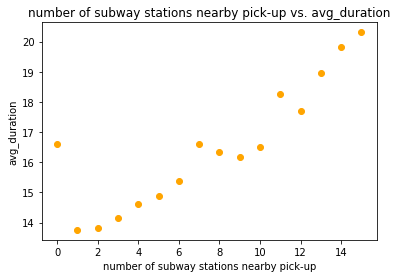

In [ ]:
plt.scatter(subway["nearby"], subway["avg_duration"], color="orange")
plt.title("number of subway stations nearby pick-up vs. avg_duration")
plt.xlabel("number of subway stations nearby pick-up")
plt.ylabel("avg_duration")

#### Conclusion




---
In this section, we discovered that pick-up locations and drop-off locations are significantly correlated with taxi fare and trip duration via the following mechanisms and channels:


*   pick-up or drop-off locations with higher occurrences, i.e., more popular, are associated with lower taxi fares and shorter trip durations.
*   pick-up locations with a larger number of nearby subway stations is associated with higher taxi fares and longer trip duration

Although there are indeed more potential mechanisms and channels that we can explore, the above two have already reassured us to confidently put pick-up and drop-off locations as well as the engineered features based on pick-up and drop-off locations as our predictors. 


---



### Time




---
We are interested in finding the correlation between what time the taxi trip happens and the associated taxi fare or trip duration.The following queries and plots showed the relationship between the taxi fare or trip duration and a specified time period in which the taxi trip occurred (whether it's the hour of day, day of week, month of the year, or day in a year). 


---



#### A. Hour of Day versus Taxi Fare and Duration





---
Hypothetically, the hour of day that a taxi trip occurs should be correlated with taxi fare and trip duration in some trend that might not be linear. One potential rationale is that taxi trips that occur during the rush hours (commuting hours, 6-10 AM and 5-7 PM) tend to be short commuting trips between residential areas and worksites, resulting in lower taxi fares and shorter trip durations. The following queries and plots corroborated this hypothesis by showing this non-linear trend between the hour of day and taxi fare or duration: taxi trips during the rush hours tend to have lower taxi fares and shorter durations.


---



In [ ]:
%%bigquery --project $project_id FarebyHour

SELECT hour, avg(avg_amount) as avg_amount, avg(avg_duration) as avg_duration
FROM(
  SELECT EXTRACT(HOUR FROM pickup_datetime) as hour, avg(tolls_amount+fare_amount) as avg_amount, 
  avg(TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE)) as avg_duration
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
  WHERE dropoff_datetime > pickup_datetime
  GROUP BY EXTRACT(YEAR FROM pickup_datetime), EXTRACT(MONTH FROM pickup_datetime), EXTRACT(DAY from pickup_datetime), EXTRACT(HOUR FROM pickup_datetime)
)
GROUP BY hour

Text(0, 0.5, 'avg_total_fare')

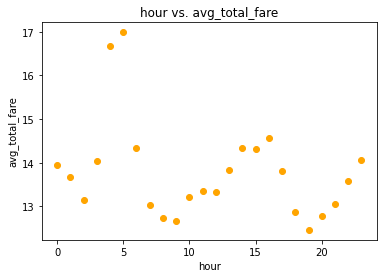

In [ ]:
plt.scatter(FarebyHour["hour"], FarebyHour["avg_amount"], color="orange")
plt.title("hour vs. avg_total_fare")
plt.xlabel("hour")
plt.ylabel("avg_total_fare")

Text(0, 0.5, 'avg_duration')

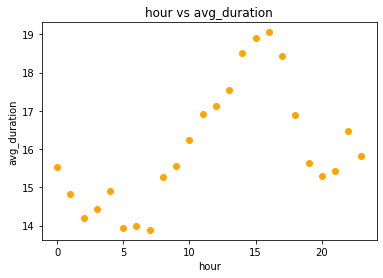

In [ ]:
plt.scatter(FarebyHour["hour"], FarebyHour["avg_duration"], color="orange")
plt.title("hour vs avg_duration")
plt.xlabel("hour")
plt.ylabel("avg_duration")

#### B. Day of Week versus Taxi Fare and Duration





---
Hypothetically, the day of week that a taxi trip occurs should be correlated with taxi fare and trip duration in some trend. One potential rationale is that taxi trips that occur during the weekends tend to be entertainment and social activies such as visiting friends, going to a movie theater, shopping, and so on. Since these weekend trips are centered around business areas, potentially hopping around each business areas (for example, taking a taxi cab to a movie theater with friends and then taking another taxi cab to a restaurant to have dinner with friends after seeing the movie), they tend to be shorter trips with lower taxi fares and shorter trip durations. We must admit that the following queries and plots only partially corroborated this hypothesis. Trips on Sunday indeed tend to have lower taxi fares and shorter trip durations, but trips on Saturday tend to have higher taxi fares and longer trip durations, and trips on Monday and Tuesday tend to have shorter durations. Our tentative explanation is that:  

*   the day of week feature may be confounded by the hour of day feature we researched above, leading to phenomenon that we cannot explain for now. 
*   there exist other rationales that we failed to discover for now. 

Still, there exist some non-trivial non-linear trends between day of week and taxi fare or duration as shown in the plot. Therefore, we included this feature as one of our predictors.


---



In [ ]:
%%bigquery --project $project_id FarebyDay

SELECT day, avg(avg_amount) as avg_amount, avg(avg_duration) as avg_duration
FROM(
  SELECT EXTRACT(DAYOFWEEK FROM pickup_datetime) as day, avg(tolls_amount+fare_amount) as avg_amount,
  avg(TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE)) as avg_duration
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
  WHERE dropoff_datetime > pickup_datetime
  GROUP BY EXTRACT(YEAR FROM pickup_datetime), EXTRACT(WEEK FROM pickup_datetime), EXTRACT(DAYOFWEEK FROM pickup_datetime)
)
GROUP BY day

Text(0, 0.5, 'avg_total_fare')

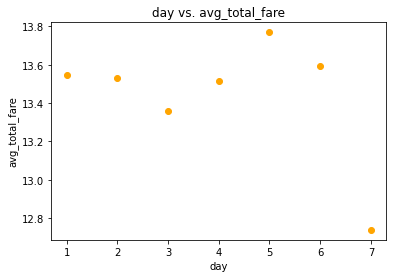

In [ ]:
plt.scatter(FarebyDay["day"], FarebyDay["avg_amount"], color="orange")
plt.title("day vs. avg_total_fare")
plt.xlabel("day")
plt.ylabel("avg_total_fare")

Text(0, 0.5, 'avg_duration')

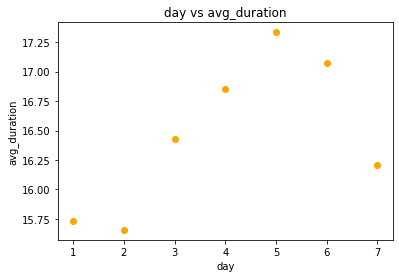

In [ ]:
plt.scatter(FarebyDay["day"], FarebyDay["avg_duration"], color="orange")
plt.title("day vs avg_duration")
plt.xlabel("day")
plt.ylabel("avg_duration")

#### C. Combination of Hour of Day and Day of Week versus Taxi Fare and Duration




---
We engineered the above two features, hoping that the engineered feature can be useful in achieving better prediction accuracies in the following data prediction section.It is reasonable to argue that since each day of week has different peak times, hour features might have different trend for each different day of week.


---



In [ ]:
%%bigquery --project $project_id FarebyDayHour

SELECT day, hour, avg(avg_amount) as avg_amount, avg(avg_duration) as avg_duration
FROM(
  SELECT EXTRACT(DAYOFWEEK FROM pickup_datetime) as day, EXTRACT(HOUR FROM pickup_datetime) as hour, avg(tolls_amount+fare_amount) as avg_amount,
  avg(TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE)) as avg_duration
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
  WHERE dropoff_datetime > pickup_datetime
  GROUP BY EXTRACT(YEAR FROM pickup_datetime), EXTRACT(WEEK FROM pickup_datetime), EXTRACT(DAYOFWEEK FROM pickup_datetime), EXTRACT(HOUR FROM pickup_datetime)
)
GROUP BY day, hour

In [ ]:
df = FarebyDayHour[FarebyDayHour['hour'] == 8]

Text(0, 0.5, 'avg_total_fare')

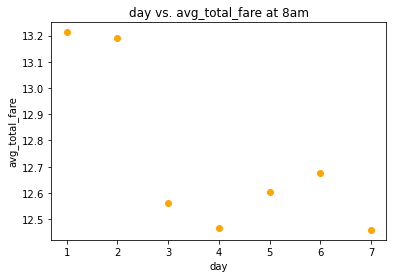

In [ ]:
plt.scatter(df["day"], df["avg_amount"], color="orange")
plt.title("day vs. avg_total_fare at 8am")
plt.xlabel("day")
plt.ylabel("avg_total_fare")

Text(0, 0.5, 'avg_duration')

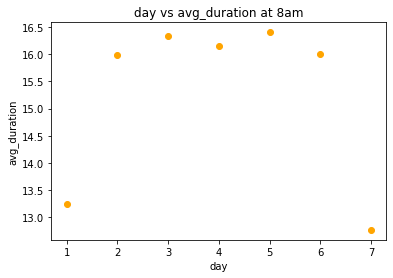

In [ ]:
plt.scatter(df["day"], df["avg_duration"], color="orange")
plt.title("day vs avg_duration at 8am")
plt.xlabel("day")
plt.ylabel("avg_duration")




---


Here we took 8am as an example to illustrate the logic behind this feature. After fixing 8am, we found a different trend across the week. Therefore, the new engineered feature that combines hour of day and day of week together might also be a solid or even better predictor.


---




#### D. Month versus Taxi Fare and Duration




---
Hypothetically, the month that a taxi trip occurs should be correlated with taxi fare and trip duration in some trend that might not be linear. One potential rationale is that some major holidays and long breaks such as Thanksgiving or Christmas are in some specific months such as November or December. Therefore, taxi trips during those months may exhibit different behaviors than those during the other months. The following queries and plots corroborated this hypothesis by showing this trend between the month and taxi fare or duration: taxi trips during January, February, March, April, August, and December tend to have lower taxi fares and shorter durations.


---



In [ ]:
%%bigquery --project $project_id FarebyMonth

SELECT month, avg(avg_amount) as avg_amount, avg(avg_duration) as avg_duration
FROM (
  SELECT EXTRACT(MONTH FROM pickup_datetime) as month, avg(tolls_amount+fare_amount) as avg_amount,
  avg(TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE)) as avg_duration
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
  WHERE dropoff_datetime > pickup_datetime
  GROUP BY EXTRACT(YEAR FROM pickup_datetime), EXTRACT(MONTH FROM pickup_datetime)
)
GROUP BY month

Text(0, 0.5, 'avg_total_fare')

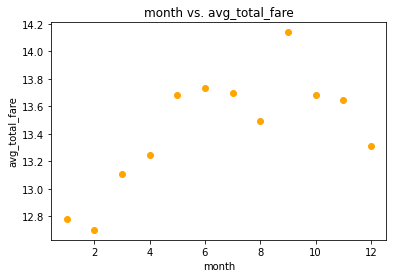

In [ ]:
plt.scatter(FarebyMonth["month"], FarebyMonth["avg_amount"], color="orange")
plt.title("month vs. avg_total_fare")
plt.xlabel("month")
plt.ylabel("avg_total_fare")

Text(0, 0.5, 'avg_duration')

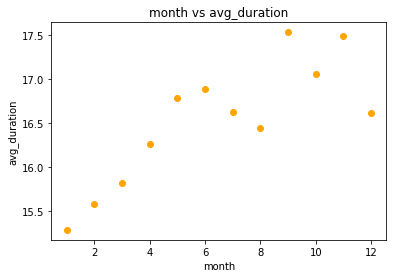

In [ ]:
plt.scatter(FarebyMonth["month"], FarebyMonth["avg_duration"], color="orange")
plt.title("month vs avg_duration")
plt.xlabel("month")
plt.ylabel("avg_duration")

#### E. Day of Year versus Taxi Fare and Duration




---
In this part, we wanted to explore the correlation between day of year and taxi fare or trip duration. Hypothetically, the correlation should not be strong since we failed to find explicit rationale about the relationship between them. We still queried the data out of exploratory interest. The following queries and plots showed that the correlations between day of year and taxi fare or trip duration are, even if existed, quite weak to be included as one of our predictors.


---



In [ ]:
%%bigquery --project $project_id FarebyYear

SELECT day, avg(avg_amount) as avg_amount, avg(avg_duration) as avg_duration
FROM (
  SELECT EXTRACT(DAYOFYEAR FROM pickup_datetime) as day, avg(tolls_amount+fare_amount) as avg_amount,
  avg(TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE)) as avg_duration
  FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
  WHERE dropoff_datetime > pickup_datetime
  GROUP BY EXTRACT(YEAR FROM pickup_datetime), EXTRACT(DAYOFYEAR FROM pickup_datetime)
)
GROUP BY day

Text(0, 0.5, 'avg_total_fare')

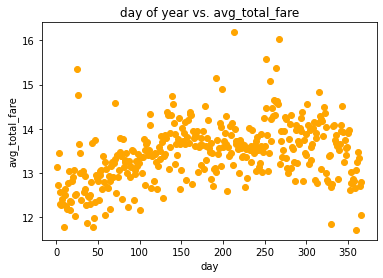

In [ ]:
plt.scatter(FarebyYear["day"], FarebyYear["avg_amount"], color="orange")
plt.title("day of year vs. avg_total_fare")
plt.xlabel("day")
plt.ylabel("avg_total_fare")

Text(0, 0.5, 'avg_duration')

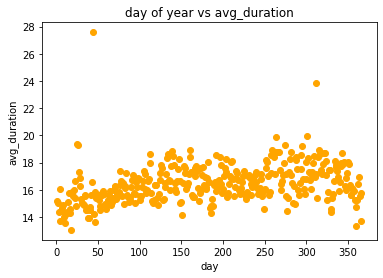

In [ ]:
plt.scatter(FarebyYear["day"], FarebyYear["avg_duration"], color="orange")
plt.title("day of year vs avg_duration")
plt.xlabel("day")
plt.ylabel("avg_duration")

### Passenger Count



---
We are interested in finding the correlation between the number of passengers and taxi fare or duration. Hypothetically, passengers with different group sizes should exhibit different behaviors in terms the distance to the desired destination. The following queries and plots showed that individual passengers and passengers with count = 6 (the maximum number you can get on a NYC yellow taxi cab including an underaged child) tend to have lower taxi fares, and that there exists an upward trend in passenger count vs trip duration. We observed an anomaly in the latter such that passenger count = 4 is associated with the lowest average trip duration. One possible explanation is that this result might be confounded by the fact that passenger count = 4 resided in this gray area of putting 1 more person on a four-seat car or putting 4 people on a six-seat car, resulting in higher variance and anomalies.


---



In [ ]:
%%bigquery --project $project_id FarebyPassenger

SELECT 
passenger_count,
avg(TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE)) as avg_duration,
avg(tolls_amount+fare_amount) as avg_total
from `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
group by 1
order by 1

In [ ]:
FarebyPassenger = FarebyPassenger[FarebyPassenger['passenger_count']<=6]
FarebyPassenger = FarebyPassenger[FarebyPassenger['passenger_count']>=1]

Text(0, 0.5, 'avg_total_fare')

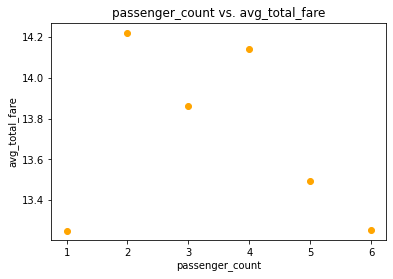

In [ ]:
plt.scatter(FarebyPassenger["passenger_count"], FarebyPassenger["avg_total"], color="orange")
plt.title("passenger_count vs. avg_total_fare")
plt.xlabel("passenger_count")
plt.ylabel("avg_total_fare")

Text(0, 0.5, 'avg_duration')

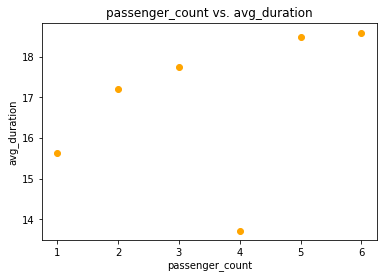

In [ ]:
plt.scatter(FarebyPassenger["passenger_count"], FarebyPassenger["avg_duration"], color="orange")
plt.title("passenger_count vs. avg_duration")
plt.xlabel("passenger_count")
plt.ylabel("avg_duration")

### Weather




---
We are interested in finding the correlation between the weather condition when the taxi trip happens and the associated taxi fare or trip duration. Our hypothesis is that bad weather conditions prompt people to take taxi cabs more often, leading to different level of taxi fares and trip durations compared with the good weather case. Also, driving in a bad weather is often associated with longer time and taking detours, so another hypothetical rationale is that bad weathers are associated with higher taxi fares and longer trip durations. The following queries and plots showed the relationship between the taxi fare or trip duration and a specified weather condition at the time the taxi trip occurred (fog, rain, snow, hail, thunder, tornado, and temperature).


---



#### A. Some Possible Weather Indicators



---
We first examined the weather condition of fog, rain, snow, hail, thunder, tornado as shown in the following plots. We noticed that hail, thunder, and tornado did not occur in NYC in 2016, at least according to our queries that defined a weather condition as "occurred" as more than or equal to half of the weather conditions report it. Also, the correlation between raining and taxi fare or trip duration is relatively weak, and therefore we decided not to include it as one of our predictors. Fog and snow exhibited strong correlation with taxi fare and trip duration in that the existence of these bad weather conditions was correlated with lower taxi fares and shorter trip durations. So, we included fog and snow as our predictors. 


---



In [ ]:
%%bigquery --project $project_id FarebyWeather

SELECT
    f.mo,
    f.da,
    f.avg_temp,
    f.fog,
    f.rain,
    f.snow,
    f.hail,
    f.thunder,
    f.tornado,
    avg(e.total_amount) as avg_total,
    avg(TIMESTAMP_DIFF(e.dropoff_datetime,e.pickup_datetime,MINUTE)) as avg_duration
FROM
(
    select
        EXTRACT(DAY FROM pickup_datetime) as day,
        EXTRACT(MONTH FROM pickup_datetime) as month,
        trip_distance,
        fare_amount,
        tip_amount,
        (tolls_amount+fare_amount) AS total_amount,
        pickup_datetime,
        dropoff_datetime
    from `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
    WHERE dropoff_datetime > pickup_datetime
)e
LEFT JOIN
(
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
)f
ON e.month = f.mo and e.day = f.da
group by 1,2,3,4,5,6,7,8,9

Text(0, 0.5, 'avg_total_fare')

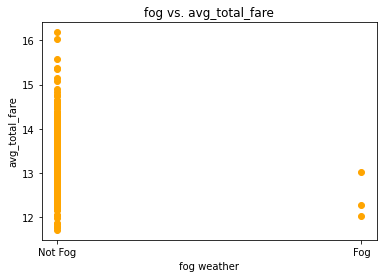

In [ ]:
plt.scatter(FarebyWeather["fog"], FarebyWeather["avg_total"], color="orange")
plt.title("fog vs. avg_total_fare")
plt.xlabel("fog weather")
plt.xticks([0,1],['Not Fog','Fog'])
plt.ylabel("avg_total_fare")

Text(0, 0.5, 'avg_duration')

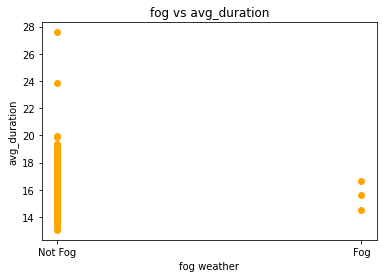

In [ ]:
plt.scatter(FarebyWeather["fog"], FarebyWeather["avg_duration"], color="orange")
plt.title("fog vs avg_duration")
plt.xlabel("fog weather")
plt.xticks([0,1],['Not Fog','Fog'])
plt.ylabel("avg_duration")

Text(0, 0.5, 'avg_total')

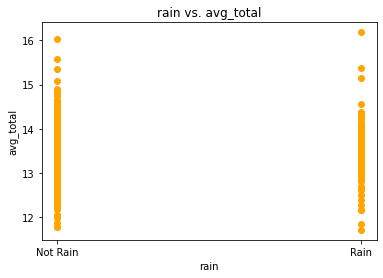

In [ ]:
plt.scatter(FarebyWeather["rain"], FarebyWeather["avg_total"], color="orange")
plt.title("rain vs. avg_total")
plt.xlabel("rain weather")
plt.xticks([0,1],['Not Rain','Rain'])
plt.ylabel("avg_total")

Text(0, 0.5, 'avg_duration')

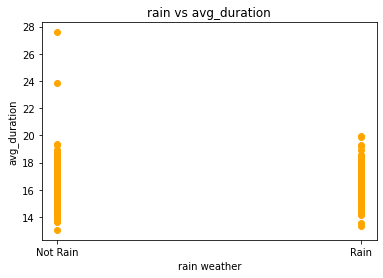

In [ ]:
plt.scatter(FarebyWeather["rain"], FarebyWeather["avg_duration"], color="orange")
plt.title("rain vs avg_duration")
plt.xlabel("rain weather")
plt.xticks([0,1],['Not Rain','Rain'])
plt.ylabel("avg_duration")

Text(0, 0.5, 'avg_total')

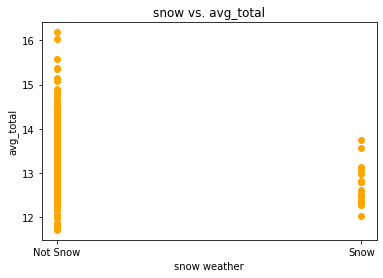

In [ ]:
plt.scatter(FarebyWeather["snow"], FarebyWeather["avg_total"], color="orange")
plt.title("snow vs. avg_total")
plt.xlabel("snow weather")
plt.xticks([0,1],['Not Snow','Snow'])
plt.ylabel("avg_total")

Text(0, 0.5, 'avg_duration')

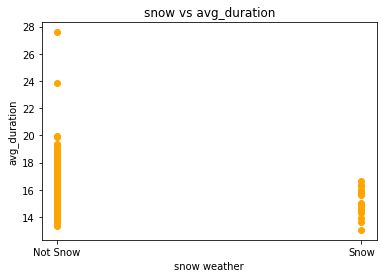

In [ ]:
plt.scatter(FarebyWeather["snow"], FarebyWeather["avg_duration"], color="orange")
plt.title("snow vs avg_duration")
plt.xlabel("snow weather")
plt.xticks([0,1],['Not Snow','Snow'])
plt.ylabel("avg_duration")

Text(0, 0.5, 'avg_total')

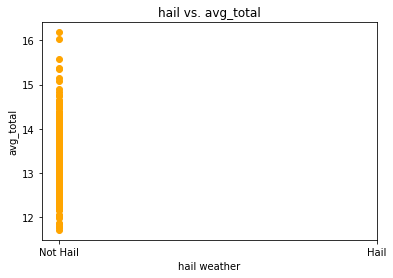

In [ ]:
plt.scatter(FarebyWeather["hail"], FarebyWeather["avg_total"], color="orange")
plt.title("hail vs. avg_total")
plt.xlabel("hail weather")
plt.xticks([0,1],['Not Hail','Hail'])
plt.ylabel("avg_total")

Text(0, 0.5, 'avg_duration')

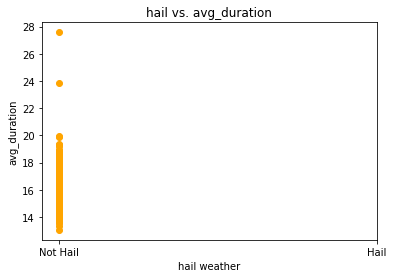

In [ ]:
plt.scatter(FarebyWeather["hail"], FarebyWeather["avg_duration"], color="orange")
plt.title("hail vs. avg_duration")
plt.xlabel("hail weather")
plt.xticks([0,1],['Not Hail','Hail'])
plt.ylabel("avg_duration")

Text(0, 0.5, 'avg_total')

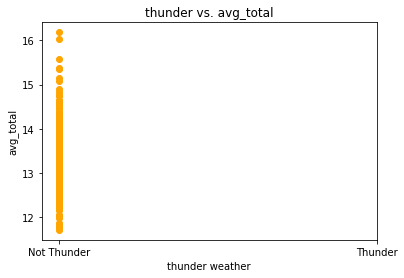

In [ ]:
plt.scatter(FarebyWeather["thunder"], FarebyWeather["avg_total"], color="orange")
plt.title("thunder vs. avg_total")
plt.xlabel("thunder weather")
plt.xticks([0,1],['Not Thunder','Thunder'])
plt.ylabel("avg_total")

Text(0, 0.5, 'avg_duration')

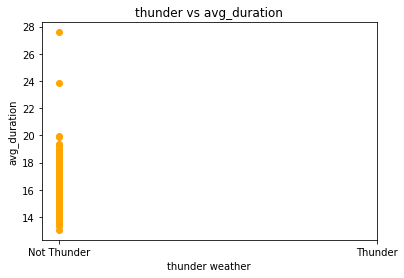

In [ ]:
plt.scatter(FarebyWeather["thunder"], FarebyWeather["avg_duration"], color="orange")
plt.title("thunder vs avg_duration")
plt.xlabel("thunder weather")
plt.xticks([0,1],['Not Thunder','Thunder'])
plt.ylabel("avg_duration")

Text(0, 0.5, 'avg_total')

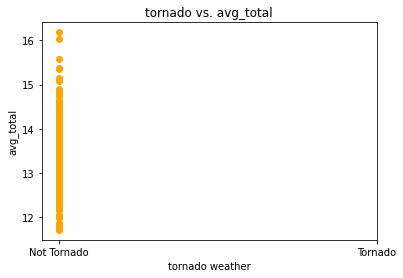

In [ ]:
plt.scatter(FarebyWeather["tornado"], FarebyWeather["avg_total"], color="orange")
plt.title("tornado vs. avg_total")
plt.xlabel("tornado weather")
plt.xticks([0,1],['Not Tornado','Tornado'])
plt.ylabel("avg_total")

Text(0, 0.5, 'avg_duration')

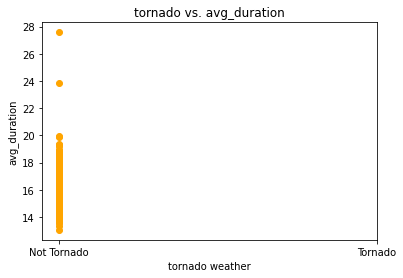

In [ ]:
plt.scatter(FarebyWeather["tornado"], FarebyWeather["avg_duration"], color="orange")
plt.title("tornado vs. avg_duration")
plt.xlabel("tornado weather")
plt.xticks([0,1],['Not Tornado','Tornado'])
plt.ylabel("avg_duration")

#### B. Selected Weather Indicators (fog and snow)



---

We do not want to many predictors since that incurs larger variance and higher flexibility in the model, potential leading to overfitting. To simplify the model, we deemed that having either fog or snow in NYC in 2018 could be considered as having a bad weather. So, we engineered a new feature that takes 1 if either fog or snow occurs and 0 otherwise. This new engineered feature preserved the correlation with taxi fares and trip durations equally well just as individual features fog and snow, as demonstrated by the following plots. We chose to use it as the weather predictor.

---



In [ ]:
%%bigquery --project $project_id FarebyWeather2

SELECT
    f.mo,
    f.da,
    f.avg_temp,
    IF(f.fog>=1 OR f.snow >= 1, 1, 0) as weather,
    avg(e.total_amount) as avg_total,
    avg(TIMESTAMP_DIFF(e.dropoff_datetime,e.pickup_datetime,MINUTE)) as avg_duration
FROM
(
    select
        EXTRACT(DAY FROM pickup_datetime) as day,
        EXTRACT(MONTH FROM pickup_datetime) as month,
        trip_distance,
        fare_amount,
        tip_amount,
        (tolls_amount+fare_amount) AS total_amount,
        pickup_datetime,
        dropoff_datetime
    from `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
    WHERE dropoff_datetime > pickup_datetime
)e
LEFT JOIN
(
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
)f
ON e.month = f.mo and e.day = f.da
group by 1,2,3,4

Text(0, 0.5, 'avg_total_fare')

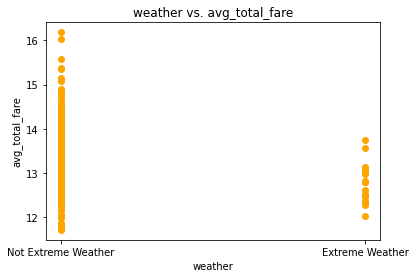

In [ ]:
plt.scatter(FarebyWeather2["weather"], FarebyWeather2["avg_total"], color="orange")
plt.title("weather vs. avg_total_fare")
plt.xlabel("weather")
plt.xticks([0,1],['Not Extreme Weather','Extreme Weather'])
plt.ylabel("avg_total_fare")

Text(0, 0.5, 'avg_duration')

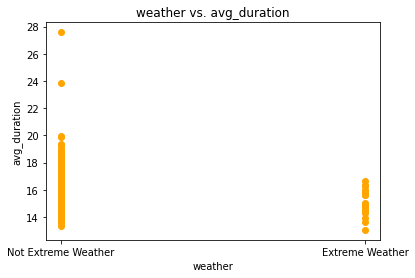

In [ ]:
plt.scatter(FarebyWeather2["weather"], FarebyWeather2["avg_duration"], color="orange")
plt.title("weather vs. avg_duration")
plt.xlabel("weather")
plt.xticks([0,1],['Not Extreme Weather','Extreme Weather'])
plt.ylabel("avg_duration")

#### C. Temperature



---
Since the temperature at the time a taxi trip happens is also a significant indicator of the weather condition at the moment, we examined the correlation between temperature and taxi fares or trip durations. The following queries and plots showed that temperature and taxi fares are positively correlated. The correlation between temperature and trip duration, though seemingly week, still captured some upward trend in the plot. Therefore, we decided to include temperature as one of our predictors.


---
 


Text(0, 0.5, 'avg_total_fare')

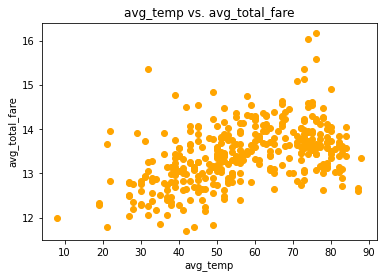

In [ ]:
plt.scatter(FarebyWeather2["avg_temp"], FarebyWeather2["avg_total"], color="orange")
plt.title("avg_temp vs. avg_total_fare")
plt.xlabel("avg_temp")
plt.ylabel("avg_total_fare")

Text(0, 0.5, 'avg_duration')

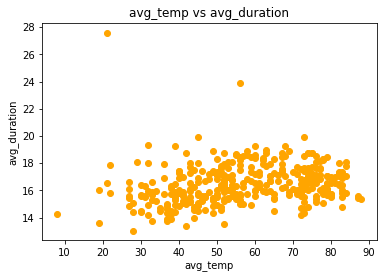

In [ ]:
plt.scatter(FarebyWeather2["avg_temp"], FarebyWeather2["avg_duration"], color="orange")
plt.title("avg_temp vs avg_duration")
plt.xlabel("avg_temp")
plt.ylabel("avg_duration")

#### Conclusion



---
There is an interesting find that we must point out to the audience. We speculated at the beginning of this section that bad weathers are associated with higher taxi fares and longer trip durations since driving in a bad weather often results in longer time and taking detours. The findings in A and B were quite the opposite: bad weather conditions are associated with lower taxi fares and shorter trip durations. We believed that the findings were confounded in the following way:

1.   controlling for the same pick-up and drop-off location, driving in a bad weather should be associated with higher taxi fares and longer trips, so our hypothesis should be solid.
2.   however, this hypothesis is true when "controlling for the same pick-up an drop-off location." In our queries and plots, we only looked at the overall correlation between bad weathers and taxi fares or trip durations.
3.   note that bad weathers may also change people's behaviors about taking taxi cabs. Facing a bad weather, people may tend to go on shorter trips to control risks. Therefore, bad weathers are associated with closer destinations already, i.e., the "controlling for the same pick-up and drop-off location" does not hold here, thus confounding our hypothesis.

Still, we believed that weather conditions are nice predictors to have in our model due to the correlation they exhibit. 






---



## Data Prediction

---

In the previous sections, we identified the following eight distinct features (excluding engineered features for now) that seem to influence taxi fares and trip durations.

*   pick-up location
*   drop-off location
*   day of week
*   hour of day
*   month
*   number of passengers
*   whether there is extreme weather (fog or snow)
*   temperature

We split the data as 80% training data, 10% testing data, and 10% predictions. The splits were calculated by hashing the pickup datetime using FARM_FINGERPRINT function, then dividing the hash value by 10. The training set includes samples with a remainder in [1,2,3,4,5,6,7,8], the validation set includes samples with a remainder of 9, and the test set includes samples with a remainder of 0.

---

### A. Model Setup

In [ ]:
model_dataset_name = 'NYC_taxi_fare_prediction'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('canvas-voltage-328019', 'NYC_taxi_fare_prediction'))

---

Here, we extracted top 10 rows from the training set to have a brief overview of the training set.

---

In [ ]:
%%bigquery --project $project_id

WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
   ),

 taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) in UNNEST(params.TRAIN)
 ),

 sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
total_fare,
dayofweek,
hourofday,
month,
pickup_longitude,
pickup_latitude,
dropoff_longitude,
dropoff_latitude,
passengers,
weather,
avg_temp
FROM sample  
limit 10    

,total_fare,dayofweek,hourofday,month,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passengers,weather,avg_temp
0,25.00,4,8,4,-73.955109,40.768780,-74.013741,40.713154,1,0,38.0
1,40.54,4,10,1,-73.982544,40.755993,-73.861969,40.768501,1,0,43.0
2,36.04,3,16,1,-73.873039,40.774071,-73.974548,40.758991,1,0,22.0
3,37.00,4,18,6,-73.989227,40.748009,-73.921822,40.867432,1,0,63.0
4,26.50,6,23,4,-73.984253,40.733223,-73.912598,40.684086,2,0,51.0
5,39.00,1,3,4,-73.631401,40.707741,-73.631401,40.707741,1,0,56.0
6,33.04,2,7,6,-73.866592,40.771248,-73.975952,40.749176,2,0,73.0
7,41.04,6,8,5,-73.977852,40.754009,-73.861771,40.768417,2,0,63.0
8,37.04,2,11,3,-73.885284,40.773064,-73.960556,40.765652,2,0,47.0
9,111.04,6,23,5,-73.790260,40.655380,-73.962059,40.900391,1,0,51.0


### B. Model Training

---

We started our training with the linear regression model on the training data using the original 8 features. Note that pick-up location and drop-off location are denoted as per their longitudes and latitudes in this case. By examining the original data, we filtered some obvious outliers which may be caused by misrecordings, such as a trip with dropoff time earlier than the pickup time, and etc..

---

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `NYC_taxi_fare_prediction.taxifare_prediction_V1` 
OPTIONS(model_type='linear_reg',labels=['total_fare']) AS

WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
   ),

 taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) in UNNEST(params.TRAIN)
 ),

 sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
total_fare,
dayofweek,
month,
hourofday,
pickup_longitude,
pickup_latitude,
dropoff_longitude,
dropoff_latitude,
passengers,
weather,
avg_temp
FROM sample      

""


---
The training info are shown below.

---

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `NYC_taxi_fare_prediction.taxifare_prediction_V1`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,2259.29651,77.517544,None,44660


### C. Evaluation on Validation Set

---

We then evaluated the model on the validation data. Although many supervised learning algorithm are designed to minimize RSS or MSE, they are hard to comprehend. Therefore, we used MAPE (mean absolute percentage error) to measure the accuracy of the prediction, given that MAPE provides a more intuitive understanding. Meanwhile, due to heteroskedasticity, higher taxi fares or longer trip durations tend to exhibit larger variance, thus leading to larger errors numerically. Using MAPE accounts for this effect.

The definition of MAPE is given below:

---

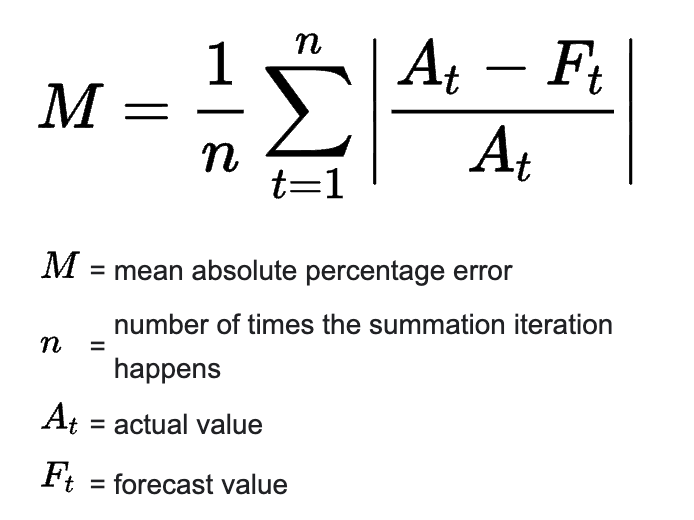

In [ ]:
%%bigquery --project $project_id

WITH predictions AS (
 SELECT
   ABS(total_fare - predicted_total_fare)/total_fare AS error
 FROM
 ML.PREDICT(MODEL NYC_taxi_fare_prediction.taxifare_prediction_V1,
 (
WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
),

taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) = params.EVAL
 ),

  sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
total_fare,
dayofweek,
hourofday,
month,
pickup_longitude,
pickup_latitude,
dropoff_longitude,
dropoff_latitude,
passengers,
weather,
avg_temp
FROM sample  
)))

SELECT
 AVG(100 * error) AS MAPE -- mean absolute percentage error
FROM predictions

,MAPE
0,50.969112


---

The MAPE is about 51% for the linear regression with the original features.

---

### D. Feature Engineering and Re-evaluation on Validation Set

---
Since the orinal model performed poorly on the validation set, we conducted some feature engineering to improve the result. 
1. In the original features, we identified each location with its exact longitude and latitude, which was too precise and gave little general information to the model (we unnecessarily created too many location categories). Thus, here we rounded the longitude and latitude to 1 digit using ST_SnapToGrid to generalize the location information.
2. From the data exploration section, we found that the pick-up and drop-off location pairs might also help. Therefore, instead of using individual pick-up and drop-off location information, we train the model with the pairs feature using Concat function.
3. From the data exploration section, we also found a correlation between the euclidean distance between pick-up and drop-off points and taxi fares or trip durations. Thus, we also introduced this feature to know more about the location information using ST_Distance.
4. Since different weekdays may have different traffic peaks, instead of treating hour of day and day of week separately, we combined them together to get a new feature. 

---

---

Here, we also extracted the top 10 rows from the training set to have a brief overview of the new features.

---

In [ ]:
%%bigquery --project $project_id

WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
   ),

 taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) in UNNEST(params.TRAIN)
 ),

 sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
total_fare,
month,
CONCAT(CAST(dayofweek AS STRING), CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample      
limit 10

,total_fare,month,dayhr_fc,distance,location_fc,passengers,weather,avg_temp
0,40.54,1,412,10804.437437,POINT(-74 40.7)POINT(-73.9 40.8),1,0,28.0
1,28.50,3,10,11296.212041,POINT(-74 40.7)POINT(-73.9 40.8),1,0,56.0
2,44.54,4,223,13898.477323,POINT(-74 40.8)POINT(-73.8 40.7),1,0,57.0
3,23.00,6,60,8263.817392,POINT(-74 40.8)POINT(-73.9 40.8),1,0,65.0
4,34.04,5,621,8753.445099,POINT(-73.9 40.8)POINT(-74 40.8),1,0,63.0
5,38.54,5,410,10583.590086,POINT(-74 40.7)POINT(-73.9 40.8),1,0,61.0
6,27.50,2,712,11048.376611,POINT(-74 40.8)POINT(-73.9 40.7),1,0,32.0
7,31.00,2,322,13454.145176,POINT(-74 40.7)POINT(-73.9 40.9),1,0,45.0
8,30.00,1,418,10479.492066,POINT(-74 40.7)POINT(-73.9 40.8),1,0,28.0
9,38.04,4,119,11403.444764,POINT(-74 40.8)POINT(-73.9 40.8),1,0,55.0


---

We then trained the model with the new features on the training data.
 
---

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `NYC_taxi_fare_prediction.taxifare_prediction` 
OPTIONS(model_type='linear_reg',labels=['total_fare']) AS

WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
   ),

 taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) in UNNEST(params.TRAIN)
 ),

 sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
total_fare,
month,
CONCAT(CAST(dayofweek AS STRING), CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample      

""


---
The training info is shown below.

---

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `NYC_taxi_fare_prediction.taxifare_prediction`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,2186.695065,12.27498,None,40711


---

We then evaluated the performace of the new features on the validation set with MAPE.

---

In [ ]:
%%bigquery --project $project_id

WITH predictions AS (
 SELECT
   ABS(total_fare - predicted_total_fare)/total_fare AS error
 FROM
 ML.PREDICT(MODEL NYC_taxi_fare_prediction.taxifare_prediction,
 (
WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
),

taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) = params.EVAL
 ),

  sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
total_fare,
month,
CONCAT(dayofweek, CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample  
)))

SELECT
 AVG(100 * error) AS MAPE -- mean absolute percentage error
FROM predictions

,MAPE
0,18.15907


---

The resulting MAPE is about 18.16%, which is a huge improvement from initial 51%. By generalizing the location information, the model can better explain the out-of-sample changes. The feature engineering works!!! 

---

### E. Training and Evaluation with Boosted Tree Regression

---

In addition to linear model, we also tried non-linear regression such as boosted tree regression.

---

---

Firstly, we trained the boosted tree regression model on the training data.

---

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `NYC_taxi_fare_prediction.taxifare_prediction_tree` 
OPTIONS(model_type='BOOSTED_TREE_REGRESSOR',labels=['total_fare']) AS

WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
   ),

 taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) in UNNEST(params.TRAIN)
 ),

 sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
total_fare,
month,
CONCAT(CAST(dayofweek AS STRING), CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample      

""


---

The training info is shown below.

---

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `NYC_taxi_fare_prediction.taxifare_prediction_tree`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,11,46.7935,3.78334,0.3,49876
1,0,10,46.7956,3.80984,0.3,66531
2,0,9,46.7990,3.85231,0.3,63741
3,0,8,46.8065,3.93804,0.3,51137
4,0,7,46.8175,4.07440,0.3,61933
5,0,6,46.8395,4.35072,0.3,60964
6,0,5,46.8821,4.83157,0.3,61027
7,0,4,46.9665,5.67710,0.3,59642
8,0,3,47.1384,7.10164,0.3,58374
9,0,2,47.4969,9.35109,0.3,57899


---

We then evaluated the model performance on the validation set using MAPE.

---

In [ ]:
%%bigquery --project $project_id

WITH predictions AS (
 SELECT
   ABS(total_fare - predicted_total_fare)/total_fare AS error
 FROM
 ML.PREDICT(MODEL NYC_taxi_fare_prediction.taxifare_prediction_tree,
 (
WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
),

taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) = params.EVAL
 ),

  sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
total_fare,
month,
CONCAT(dayofweek, CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample  
)))

SELECT
 AVG(100 * error) AS MAPE -- mean absolute percentage error
FROM predictions

,MAPE
0,17.104271


---

The resulting MAPE is 17.10%, which shows that by introducing non-linear terms the prediction performs better. However, we should also notice that the improvement is really slight (from 18.16% to 17.10%). Thus, we can conclude that the most of the variation can be explained by the linear terms. Additionally, we also noticed that the boosted tree takes much longer to execute than the linear regression. With the trade-off between accuracy and computation, we may conclude that linear regression is a good enough model.

---

### F. Prediction on Test Set with Boosted Tree Regression

---

For the prediction here, since we want to make a more concise estimation, we still employ the boosted tree regression to make a prediction on the test data.

---

In [ ]:
%%bigquery --project $project_id prediction_fare

SELECT
*
FROM
  ML.PREDICT(MODEL `NYC_taxi_fare_prediction.taxifare_prediction_tree`, (
  WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
   ),

  taxitrips AS (
  SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) = params.TEST
 ),  

  sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )
SELECT
total_fare,
month,
CONCAT(dayofweek, CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample  
))

---

The top 10 rows of the prediction results are shown below.

---

In [ ]:
prediction_fare.head(10)

,predicted_total_fare,total_fare,month,dayhr_fc,distance,location_fc,passengers,weather,avg_temp
0,6.187973,3.5,4,414,606.594180,POINT(-74 40.8)POINT(-74 40.8),1,0,47.0
1,7.970530,3.5,4,10,515.383202,POINT(-74 40.8)POINT(-74 40.8),1,1,42.0
2,6.252859,3.5,1,417,838.108675,POINT(-74 40.8)POINT(-74 40.8),6,0,31.0
3,6.189398,4.0,6,119,686.689451,POINT(-74 40.8)POINT(-74 40.8),2,0,74.0
4,6.561848,4.0,5,614,1084.567281,POINT(-74 40.7)POINT(-73.9 40.7),1,0,60.0
5,10.670028,4.0,1,615,2607.407711,POINT(-74 40.7)POINT(-74 40.7),1,0,40.0
6,7.846366,4.0,5,38,248.789520,POINT(-74 40.7)POINT(-74 40.8),1,0,57.0
7,7.699298,4.0,6,319,438.913530,POINT(-74 40.8)POINT(-74 40.8),1,0,76.0
8,7.896212,4.0,4,414,374.593543,POINT(-74 40.7)POINT(-74 40.7),1,0,47.0
9,8.058982,4.0,6,518,250.303246,POINT(-74 40.8)POINT(-74 40.8),1,0,62.0


In [ ]:
df = prediction_fare
df['error'] = abs(df['predicted_total_fare']-df['total_fare'])
df = df.sort_values(by = ['error'],ascending = [False])

Text(0, 0.5, 'error')

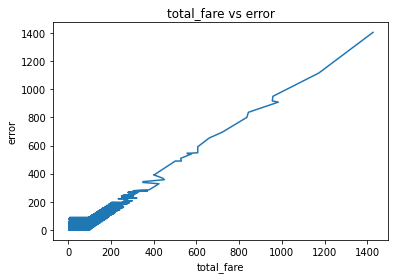

In [ ]:
plt.plot(df['total_fare'],df['error'])
plt.title("total_fare vs error")
plt.xlabel("total_fare")
plt.ylabel("error")

---

From the figure above, we observed a trend that with an increasing taxi fares, the error also increased. This trend indicates that our model performs poorly with the extremely large taxi fares. However, it is rare and strange that there exists some orders above $1000 when we are dealing with trips within NYC. A possible reason might be that those records are actually mistaken, requiring further exploration.

---

In [ ]:
%%bigquery --project $project_id

WITH predictions AS (
 SELECT
   ABS(total_fare - predicted_total_fare)/total_fare AS error
 FROM
 ML.PREDICT(MODEL NYC_taxi_fare_prediction.taxifare_prediction_tree,
 (
WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
),

taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) = params.TEST
 ),

  sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
total_fare,
month,
CONCAT(dayofweek, CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample  
)))

SELECT
 AVG(100 * error) AS MAPE -- mean absolute percentage error
FROM predictions

,MAPE
0,17.1038


---

We also evaluated the MAPE on the test data, resulting in a MAPE of 17.10%, which is very close to the validation MAPE.

---

### G. Prediction of Duration with Boosted Tree Regression

---

We are also interested in predicting trip durations. Here, we also fit a boosted tree regression (which is the best model for taxi fares prediction) on trip durations to get some intuition.

---

---

Here, we also extracted top 10 rows from the training set to have a brief overview of the new features.

---

In [ ]:
%%bigquery --project $project_id

WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
   ),

 taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) in UNNEST(params.TRAIN)
 ),

 sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
duration,
month,
CONCAT(CAST(dayofweek AS STRING), CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample 
limit 10     

,duration,month,dayhr_fc,distance,location_fc,passengers,weather,avg_temp
0,32,6,62,9740.784070,POINT(-74 40.8)POINT(-74 40.7),2,0,67.0
1,24,4,60,14691.357337,POINT(-73.8 40.6)POINT(-73.9 40.7),1,0,48.0
2,19,2,215,9908.539365,POINT(-74 40.8)POINT(-73.9 40.8),3,1,37.0
3,28,3,721,9522.920985,POINT(-74 40.8)POINT(-73.9 40.8),5,0,47.0
4,15,5,42,13553.728505,POINT(-74 40.7)POINT(-73.9 40.9),1,0,72.0
5,20,4,718,8646.713947,POINT(-73.9 40.8)POINT(-74 40.8),1,0,41.0
6,38,1,117,10045.759768,POINT(-74 40.8)POINT(-74 40.7),1,0,39.0
7,40,5,423,10592.901978,POINT(-74 40.8)POINT(-74 40.7),1,0,72.0
8,28,6,418,9245.053618,POINT(-73.9 40.8)POINT(-74 40.8),3,0,73.0
9,41,2,321,18267.117565,POINT(-74 40.8)POINT(-74 40.6),2,0,45.0


---

Then we trained the model on the training data.

---

In [ ]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `NYC_taxi_fare_prediction.duration_prediction_tree` 
OPTIONS(model_type='BOOSTED_TREE_REGRESSOR',labels=['duration']) AS

WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
   ),

 taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) in UNNEST(params.TRAIN)
 ),

 sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
duration,
month,
CONCAT(CAST(dayofweek AS STRING), CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample      

""


---

The training info is below.

---

In [ ]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `NYC_taxi_fare_prediction.duration_prediction_tree`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,3,134.035,48.0778,0.3,60613
1,0,2,134.151,48.4784,0.3,47047
2,0,1,134.344,49.3165,0.3,289224


---

We evaluated the fitted model on the evaluation data, resulting in a MAPE of 32.19%. 

We did not show our trial to fit a linear regression here, since the non-linear model performed better in this case. The intuition might be that since trip durations are affected by the traffic, the actual route and etc in a more non-linear fashion rather than simple euclidean distances, non-linear models tend to perform much better.

---

In [ ]:
%%bigquery --project $project_id

WITH predictions AS (
 SELECT
   ABS(duration - predicted_duration)/duration AS error
 FROM
 ML.PREDICT(MODEL NYC_taxi_fare_prediction.duration_prediction_tree,
 (
WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
),

taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) = params.EVAL
 ),

  sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
duration,
month,
CONCAT(dayofweek, CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample  
)))

SELECT
 AVG(100 * error) AS MAPE -- mean absolute percentage error
FROM predictions

,MAPE
0,32.187813


---

Finally, we made a prediction on the test data.

---

In [ ]:
%%bigquery --project $project_id prediction_duration

SELECT
*
FROM
  ML.PREDICT(MODEL `NYC_taxi_fare_prediction.duration_prediction_tree`, (
  WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
   ),

  taxitrips AS (
  SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) = params.TEST
 ),  

  sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )
SELECT
duration,
month,
CONCAT(dayofweek, CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample  
))

---

The top 10 rows of the prediction results are shown below.

---

In [ ]:
prediction_duration.head(10)

,predicted_duration,duration,month,dayhr_fc,distance,location_fc,passengers,weather,avg_temp
0,21.020071,20,5,323,8967.328341,POINT(-74 40.7)POINT(-74 40.8),2,0,59.0
1,20.440243,24,3,120,9499.387081,POINT(-73.9 40.8)POINT(-74 40.8),1,0,56.0
2,18.296032,24,3,223,9268.000596,POINT(-74 40.8)POINT(-73.9 40.7),2,1,39.0
3,25.340467,45,5,519,14972.545334,POINT(-73.8 40.6)POINT(-74 40.6),1,0,78.0
4,16.727938,16,3,521,7113.674985,POINT(-73.9 40.8)POINT(-73.9 40.8),1,0,50.0
5,12.273463,24,2,321,3792.442531,POINT(-74 40.7)POINT(-74 40.7),3,0,39.0
6,13.899489,42,6,511,4208.004575,POINT(-74 40.8)POINT(-74 40.7),1,0,62.0
7,24.180477,51,4,217,15326.692329,POINT(-73.9 40.8)POINT(-74 40.7),1,0,57.0
8,19.705402,27,4,67,9005.028808,POINT(-74 40.8)POINT(-73.9 40.8),1,0,67.0
9,19.833910,32,5,613,8820.265287,POINT(-73.9 40.8)POINT(-73.9 40.7),2,0,60.0


---

Again, we evaluated the MAPE on the test data, which results in a MAPE of 32.19%, very close to the validation MAPE.

---

In [ ]:
%%bigquery --project $project_id

WITH predictions AS (
 SELECT
   ABS(duration - predicted_duration)/duration AS error
 FROM
 ML.PREDICT(MODEL NYC_taxi_fare_prediction.duration_prediction_tree,
 (
WITH params AS (
   SELECT
   [1,2,3,4,5,6,7,8] AS TRAIN,
   9 AS EVAL,
   0 AS TEST
),

taxitrips AS (
 SELECT
   (tolls_amount + fare_amount) AS total_fare,
   EXTRACT(DAY FROM pickup_datetime) as day,
   EXTRACT(MONTH FROM pickup_datetime) as month,
   EXTRACT(DAYOFWEEK FROM pickup_datetime) as dayofweek,
   EXTRACT(HOUR FROM pickup_datetime) AS hourofday,
   pickup_longitude,
   pickup_latitude,
   dropoff_longitude,
   dropoff_latitude,
   ST_GeogPoint(pickup_longitude, pickup_latitude) AS pickup,
   ST_GeogPoint(dropoff_longitude, dropoff_latitude) AS dropoff,
   passenger_count AS passengers,
   TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) as duration
 FROM
   `bigquery-public-data.new_york.tlc_yellow_trips_2016`, params
 WHERE
   trip_distance > 0 AND fare_amount > 2.5 AND TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,MINUTE) > 3
   AND passenger_count>0 AND passenger_count<=6
   AND pickup_longitude > -75 and pickup_longitude < -73
     and dropoff_longitude > -75 and dropoff_longitude < -73 and pickup_latitude > 40
     and pickup_latitude < 41 and dropoff_latitude > 40 and dropoff_latitude < 41
   AND MOD(ABS(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING))),10) = params.TEST
 ),

  sample AS (
 SELECT
   e.total_fare,
   e.month,
   e.day,
   e.dayofweek,
   e.hourofday,
   e.pickup_longitude,
   e.pickup_latitude,
   e.dropoff_longitude,
   e.dropoff_latitude,
   pickup,
   dropoff,
   e.passengers,
   e.duration,
   avg_temp,
   IF(f.fog+f.snow>=1, 1, 0) as weather
 FROM taxitrips e
 LEFT JOIN
 (
    select 
        CAST(c.mo AS INT) as mo,
        CAST(c.da AS INT) as da,
        round(avg(c.temp)) as avg_temp,
        IF(AVG(CAST(c.fog AS INT))>0.5,1,0) as fog,
        IF(AVG(CAST(c.rain_drizzle AS INT))>0.5,1,0) as rain,
        IF(AVG(CAST(c.snow_ice_pellets AS INT))>0.5,1,0) as snow,
        IF(AVG(CAST(c.hail AS INT))>0.5,1,0) as hail,
        IF(AVG(CAST(c.thunder AS INT))>0.5,1,0) as thunder,
        IF(AVG(CAST(c.tornado_funnel_cloud AS INT))>0.5,1,0) as tornado
    FROM `bigquery-public-data.noaa_gsod.gsod2016` c
    JOIN
    (
        SELECT
            a.usaf,
            a.wban,
            a.name
        FROM (select * from `bigquery-public-data.noaa_gsod.stations` where country = 'US' and state = 'NY') a
        CROSS JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` b
        WHERE ST_COVERS(b.zone_geom,ST_GEOGPOINT(a.lon,a.lat)) is TRUE
    ) d
    on c.stn = d.usaf and c.wban = d.wban
    group by 1,2
 )f
ON e.month = f.mo and e.day = f.da
 )

SELECT
duration,
month,
CONCAT(dayofweek, CAST(hourofday AS STRING)) AS dayhr_fc,
ST_Distance(pickup, dropoff) AS distance,
CONCAT(ST_AsText(ST_SnapToGrid(pickup, 0.1)),ST_AsText(ST_SnapToGrid(dropoff, 0.1))) location_fc,
passengers,
weather,
avg_temp
FROM sample  
)))

SELECT
 AVG(100 * error) AS MAPE -- mean absolute percentage error
FROM predictions

,MAPE
0,32.186265


## Conclusion

---

In conclusion, we were satisfied with the the discovered trends and correlations that can be used to predict taxi fares and trip durations. We observed that different pick-up locations and drop-off locations are associated with different levels of taxi fares and trip durations via the channels of location occurrences and the number of nearby subway stations. More popular pick-up or drop-off locations are associated with lower taxi fares and shorter trip durations. Pick-up locations with more nearby subway stations tend to be associated with higher taxi fares and longer trip duratons.Through feature engineering based on locations, we discoverd that pick-up drop-off location pairs and the euclidean distances between pick-up and drop-off are better predictors of taxi fares and trip durations. Euclidean distances are positively correlated with taxi fares and trip durations as expected. We also observed that hour of day, day of week, the combination of the two, and month exhibit some useful non-linear trends that can be utilized in predicting. similarly, we witnessed some non-linear correlation between passenger counts and taxi fares or trip durations. Lastly, we identified fog, snow, and temperature to be useful weather predictors. Meanwhile, we chose not to include some features in our prediction model due to either weak correlations or non-existence: day of year, rain, hail (did not happen in NYC in 2016), thunder (did not happen in NYC in 2016), and tornado (did not happen in NYC in 2016).

We had encountered some anomalies that we cannot provide detailed explanations yet. For example, when the number of subway stations near a pick-up location is 0, the associated taxi fare is high and the trip duration long, contrary to the general trend and our hypothesis. We believed that this phenomenon is due to the small size of the data that correspond to the number = 0 case, leading to higher variance and anomalies. Still, more exploration could be done to dig deeper into studying the rationales behind. Some other aberrations include the trend in day of week versus taxi fare and duration, which cannot be fully explained by our prior hypothesis, the trend in passenger count versus duration in which the number = 4 case looks like an outlier. One important anomaly is that the bad weather conditions are associated with lower taxi fares and shorter trip durations, opposite to what we speculated. We provided some tentative explanations to these anomalies in the data exploration part. 

One potential limit of our model and analysis is its external validity. We only explored the 2016 dataset for NYC taxi trips and we are only certain about whether the result attained can be applied in other settings such as the year 2021 or 2020. One notable example is that in 2016, hail, thunder, and tornado did not happen in NYC, so we did not include them in our model. However, these weather conditions may occur in other years and may need to be included as predicotrs. A more thorough analysis could be done by using datasets in each year to perform panel data regression analysis rather than single year. 

Another potential limit is that we did not explore the the interactions between our existing features such as the interaction between locations and timestamps and its impact on taxi fares and trip durations. For example, taxi trips during rush hours may tend to be commuting trips between residential areas and worksites as we discussed previously in the data exploration section. A more detailed research could be conducted to include interaction terms as predictors. We chose not to do so due to limits on our computing powers.

The last potential limit is that we established pick-up drop-off location pairs by tuning the latitude/longitude with precision 0.1. For example, all latitudes/longitudes with (-73.9, 40.7) as to the first decimal place were categorized as one location pair. This procedure may not be optimal since 0.1 difference in latitude/longitude is equivalent to 10 kilometers, a measure that might still be too large. We selected not to tune with higher precision due to limits on our computing power. Given enough time and computation support, a more precise model could be trained.

---